In [ ]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement
# We will explain it as we go through this code 

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

# ##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
# ##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

conda install conda-forge::r-fmesher
conda install conda-forge::r-exactextractr
conda install conda-forge::r-sn
conda install conda-forge::r-inlabru
conda install conda-forge::r-fields

In [ ]:
############## LOAD PACKAGES ###########

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
# library(exactextractr)

library(ggplot2)
library(viridis)
library(stringr)
# library(sn)


Call:
lm(formula = NFI$AG_Biomass..Mg.ha. ~ NFI$GEDI_L4A)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.409  -3.093  -2.034   1.833  32.391 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.03385    0.31511   6.454 1.91e-10 ***
NFI$GEDI_L4A  0.83465    0.03136  26.618  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.022 on 781 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4757,	Adjusted R-squared:  0.475 
F-statistic: 708.5 on 1 and 781 DF,  p-value: < 2.2e-16


Warning message in NFI$AG_Biomass..Mg.ha. - predictions:
“longer object length is not a multiple of shorter object length”


[1] "RMSE: 8.04328274711149"


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


,lm():Mean,lm():SE,inla():Mean,inla():SD,inla():0.025quant,inla():0.5quant,inla():0.975quant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.033853,0.31510927,2.0297705,0.31453198,1.4128400,2.0297705,2.6467011
NFI$GEDI_L4A,0.834655,0.03135682,0.8349002,0.03131934,0.7734697,0.8349002,0.8963307


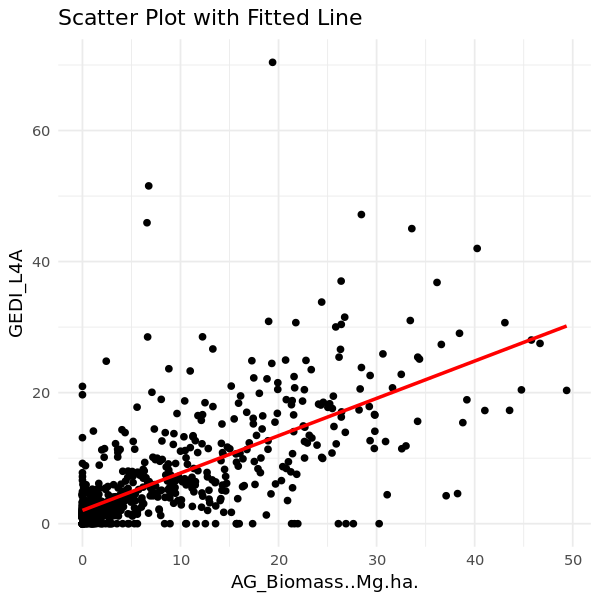

In [120]:
options(repr.plot.width=5, repr.plot.height=5)
NFI = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv")
# plot(NFI$AG_Biomass..Mg.ha.,NFI$CCI)
# plot(NFI$AG_Biomass..Mg.ha.,NFI$TC)
# plot(NFI$AG_Biomass..Mg.ha.,NFI$HEIGHT)
# plot(NFI$AG_Biomass..Mg.ha.,NFI$GEDI_L4A,xlim=c(0,70),ylim=c(0,70))

LM_model <- (lm(NFI$AG_Biomass..Mg.ha.~ NFI$GEDI_L4A))
summary(LM_model)
predictions <- predict(LM_model)
residuals <- NFI$AG_Biomass..Mg.ha. - predictions
rmse <- sqrt(mean(residuals^2))
print(paste("RMSE:", rmse))

ggplot(NFI, aes(x = AG_Biomass..Mg.ha., y = GEDI_L4A)) +
  geom_point() +  # Scatter points
  geom_smooth(method = "lm", se = FALSE, color = "red") +  # Fit line
  labs(title = "Scatter Plot with Fitted Line", x = "AG_Biomass..Mg.ha.", y = "GEDI_L4A") + theme_minimal()

formula = (AG_Biomass..Mg.ha.)~ (GEDI_L4A)
INLA_model <- inla(formula, data=NFI, family="gaussian",control.compute=list(config = T, dic = T, waic = T, cpo=TRUE)) #option cpo is a leave-one-out cross validation
# summary(INLA_model)

#### Let's do a quick comparison, just to see how our outputs compare 
output <- cbind(summary(LM_model)$coef[,1:2],INLA_model$summary.fixed[,1:5]) # Looking great! 
colnames(output) <- c("lm():Mean","lm():SE","inla():Mean","inla():SD","inla():0.025quant","inla():0.5quant","inla():0.975quant")
output # Looking great! 

Reading layer `Sudan_country' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_country.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.84084 ymin: 8.684103 xmax: 38.58349 ymax: 23.13772
Geodetic CRS:  WGS 84

	Moran I test under randomisation

data:  DATA$AG_Biomass..Mg.ha.  
weights: listw    

Moran I statistic standard deviate = 19.641, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.655948398      -0.001277139       0.001119740 



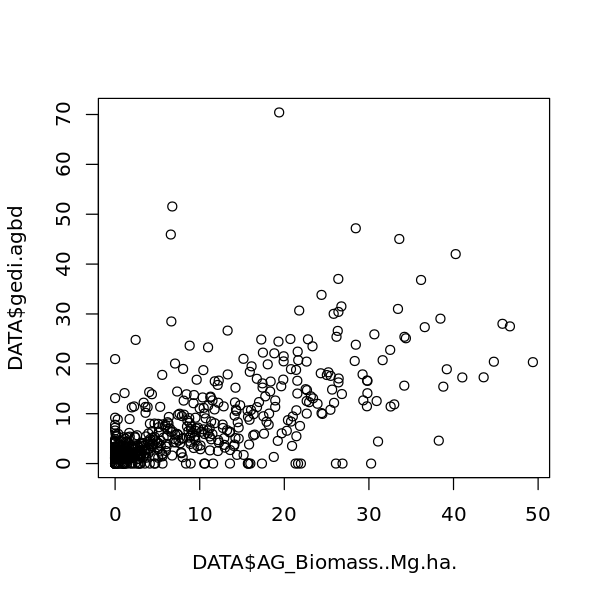

In [86]:
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_country.gpkg")
Sudan <- Sudan %>% st_transform(crs=6933)
FNF <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_FNF_probability_2023.tif")
THRESHOLD_FOREST_PROBABILITY = 0

DATA = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv")
DATA$gedi.agbd <- (DATA$GEDI_L4A)
DATA$HANSEN.tc <- (DATA$TC)
DATA$CCI.agb <- (DATA$CCI)
DATA$HEIGHT.agb <- (DATA$HEIGHT)

coordinates <- cbind(DATA$X, DATA$Y)
neighbors <- knn2nb(knearneigh(coordinates, k = 2)) 
listw <- nb2listw(neighbors)
moran_result <- moran.test(DATA$AG_Biomass..Mg.ha., listw)
print(moran_result)

# A very high standard deviation like 19.641 suggests that the observed value is significantly different from the expected mean (which is usually 0).
# This p-value is extremely small, indicating strong statistical significance.

dt = sort(sample(nrow(DATA), nrow(DATA)*0.9))
DATA <- DATA[dt,]
write.csv(DATA,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv",row.names=FALSE) #Save the data
DATA_TEST <- DATA[-dt,]
write.csv(DATA_TEST,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv",row.names=FALSE) 
plot(DATA$AG_Biomass..Mg.ha.,DATA$gedi.agbd) #Save the data

Reading layer `ne_10m_admin_0_countries' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.80945 ymin: 8.681642 xmax: 38.60385 ymax: 22.22696
Geodetic CRS:  WGS 84


Time used:
    Pre = 0.616, Running = 31.8, Post = 1.25, Total = 33.6 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 0.905 0.349      0.222    0.905      1.588 0.905   0
L4A       0.051 0.011      0.029    0.051      0.072 0.051   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 5.33e+00 3.90e-01   4.59e+00 5.32e+00
Range for alpha.spat                    8.84e+05 3.71e+05   4.20e+05 8.03e+05
Stdev for alpha.spat                    5.97e-01 1.55e-01   3.68e-01 5.73e-01
Range for beta.spat                     3.38e+05 1.61e+05   1.27e+05 3.04e+05
Stdev for beta.spat                     2.60e-02 7.00e-03   1.50e-02 2.50e-02
                                        0.975quant     mode
Precision for the Gaussian observations   6.13e+00 5.30e+00
Range for alpha.spat         

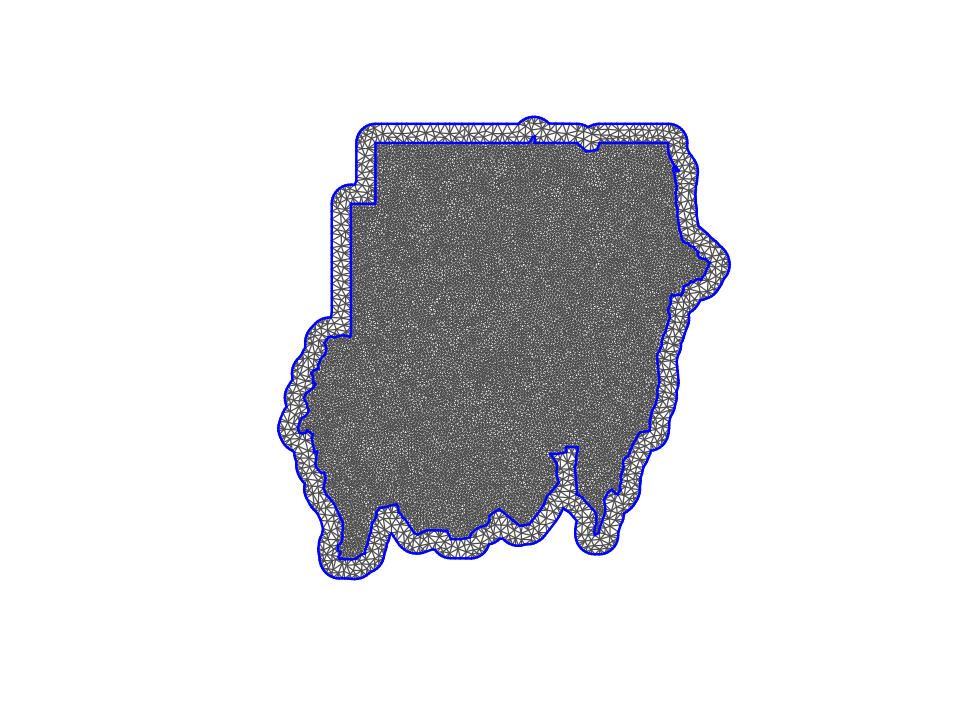

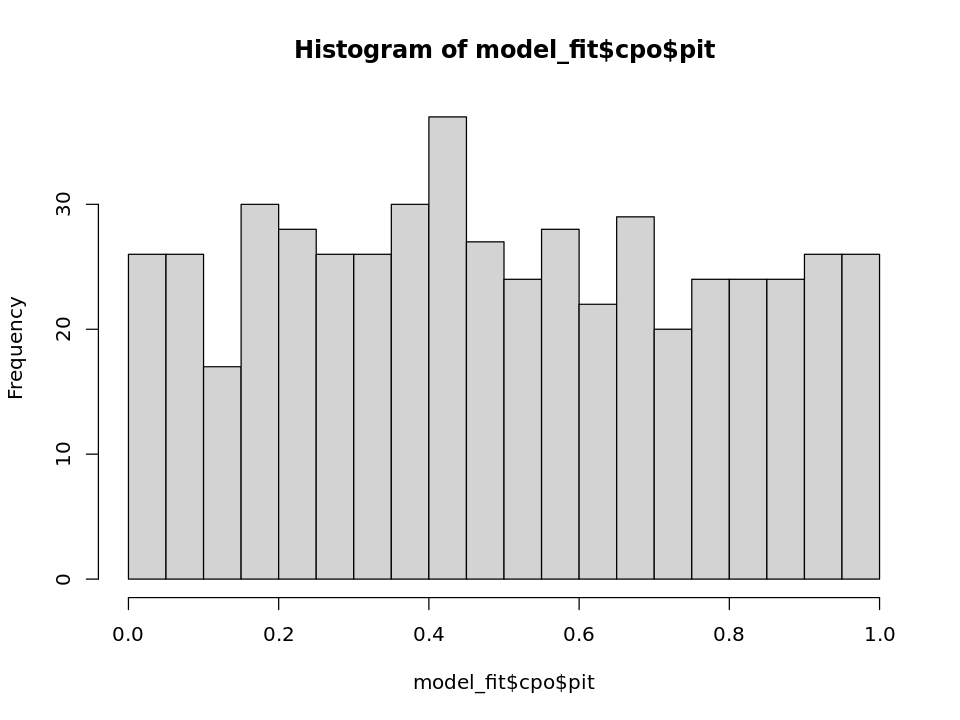

In [87]:
###############################################################
###############################################################
options(repr.plot.width=8, repr.plot.height=6)
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg")
Sudan <- Sudan %>% st_transform(crs=6933)

DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv")
DATA <- DATA[DATA$gedi.agbd > 0,]
DATA <- DATA[DATA$AG_Biomass..Mg.ha. > 0,]
factor <- (1/3)
DATA$AG_Biomass..Mg.ha. <- (DATA$AG_Biomass..Mg.ha.)^factor

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
nfi.agbd <- DATA$AG_Biomass..Mg.ha.
gedi.agbd <- DATA$gedi.agbd
HANSEN.tc <- DATA$HANSEN.tc
CCI.agb <- DATA$CCI.agb

max.edge = 15*10^3
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
plot(mesh)

n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  L4A + 
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) 

## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = nfi.agbd),
                   A = list(1, # tell INLA we expect an intercept, and the projection matrix is just "1"
                            1, # tell INLA we expect a cci biomass value, and the projection matrix for its parameter is just "1"
                            A.plot, # tell INLA we have a mesh projected onto the plot locations for alpha-tilde 
                            Diagonal(x = gedi.agbd)%*%A.plot), # tell INLA to multiply our mesh with CCI values for beta-tilde
                   effects = list(
                     intercept = rep(1, n.plot), # The intercept just given an index equal to 1
                     L4A = gedi.agbd, # Supply INLA with the CCI values
                     alpha.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     beta.spat = 1:k
                   ))

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)

summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


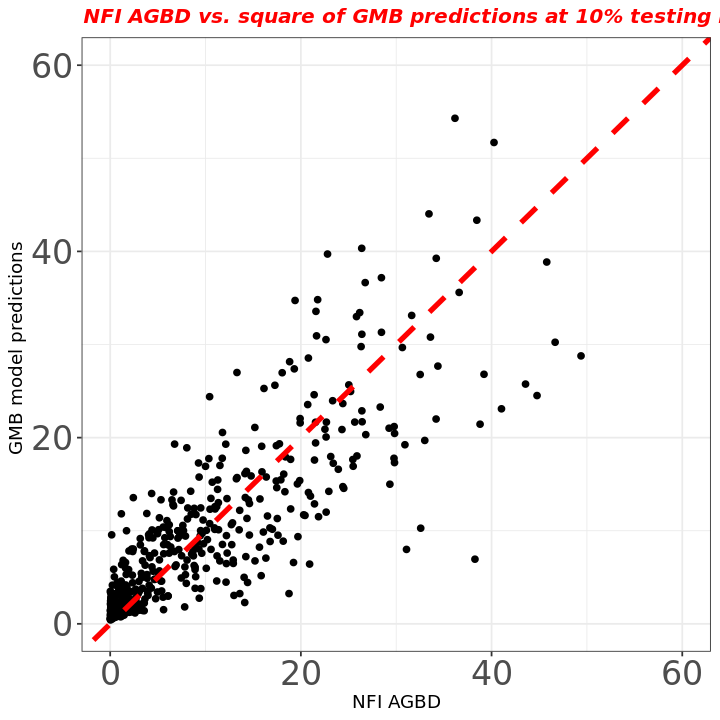

In [103]:
###############################################################
###############################################################
samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    gedi.agbd*L4A +
    A.plot%*%alpha.spat[1:k] +   
    Diagonal(x = gedi.agbd)%*%A.plot%*%beta.spat[1:k]) + 
    rnorm(nrow(A.plot), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, var)
options(repr.plot.width=5, repr.plot.height=5)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=nfi.agbd^(1/factor), PRED.SD=pred.sd, RES=nfi.agbd^(1/factor)-pred.mu))
options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,60) + ylim(0,60) + xlab("NFI AGBD") + ylab("GMB model predictions ") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))

In [89]:
######################## HEURISTICS: R2 AND RMSE ###################
R2_backtrans = 1 - (sum((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE)/sum((nfi.agbd^(1/factor) - mean(nfi.agbd^(1/factor),na.rm=TRUE))^2,na.rm=TRUE))
R2_backtrans
RMSE = sqrt(mean((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE))
RMSE
BIAS = mean(pred.mu,na.rm=TRUE) - mean(nfi.agbd_T^(1/factor),na.rm=TRUE)
BIAS

[1] 0.719403

[1] 5.388845

[1] 0.7109718

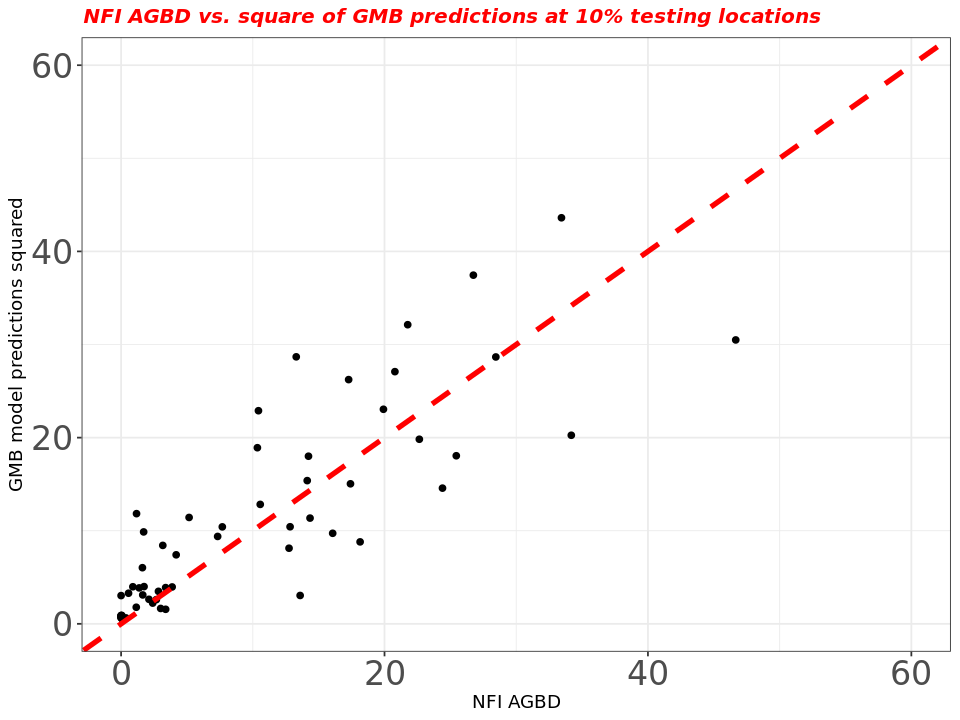

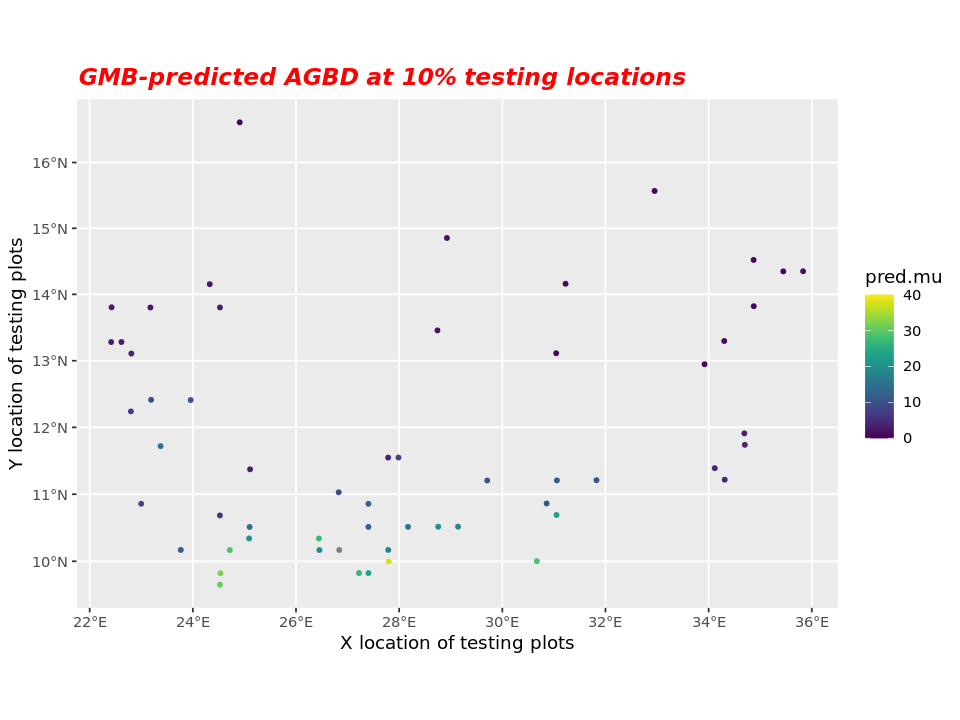

In [90]:
###############################################################
###############################################################
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv")
DATA_TEST <- DATA_TEST[DATA_TEST$gedi.agbd > 0,]
DATA_TEST$AG_Biomass..Mg.ha. <- (DATA_TEST$AG_Biomass..Mg.ha.)^factor

loc.plot_T <- data.matrix(as.data.frame(cbind(DATA_TEST$X,DATA_TEST$Y)))
nfi.agbd_T <- DATA_TEST$AG_Biomass..Mg.ha.
GEDI.pred <- DATA_TEST$gedi.agbd

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    GEDI.pred*L4A +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, var)
options(repr.plot.width=5, repr.plot.height=5)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=nfi.agbd_T^(1/factor), PRED.SD=pred.sd, RES=nfi.agbd_T^(1/factor)-pred.mu))
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,60) + ylim(0,60) + xlab("NFI AGBD") + ylab("GMB model predictions ") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))

####################### And here are some maps to see what the predictions look like at the plot locations ##########
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 40)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("GMB-predicted AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

In [91]:
######################## HEURISTICS: R2 AND RMSE ###################
R2_backtrans = 1 - (sum((pred.mu - nfi.agbd_T^(1/factor))^2,na.rm=TRUE)/sum((nfi.agbd_T^(1/factor) - mean(nfi.agbd_T^(1/factor),na.rm=TRUE))^2,na.rm=TRUE))
R2_backtrans
RMSE = sqrt(mean((pred.mu - nfi.agbd_T^(1/factor))^2,na.rm=TRUE))
RMSE
BIAS = mean(pred.mu,na.rm=TRUE) - mean(nfi.agbd_T^(1/factor),na.rm=TRUE)
BIAS

[1] 0.6675938

[1] 6.178858

[1] 1.18694

In [92]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA.csv")
nrow(DATA)
DATA <- DATA[DATA$gedi.agbd > 0,]
nrow(DATA)
DATA_TEST <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/DATA_TEST.csv")
nrow(DATA_TEST)
DATA <- DATA_TEST[DATA_TEST$gedi.agbd > 0,]
nrow(DATA_TEST)

[1] 705

[1] 628

[1] 70

[1] 70

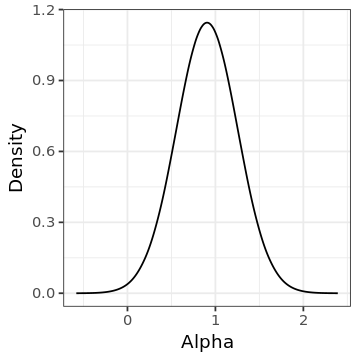

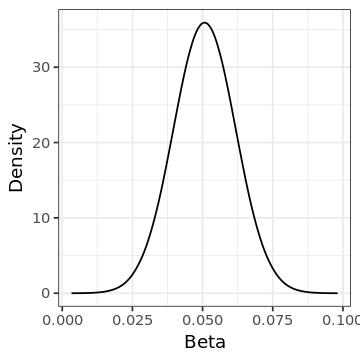

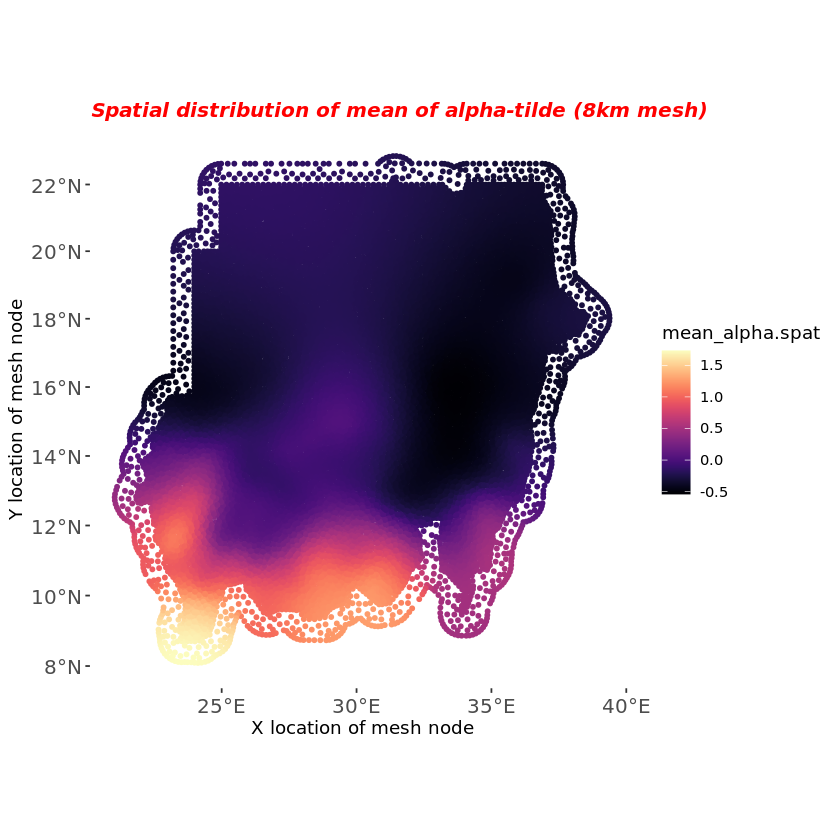

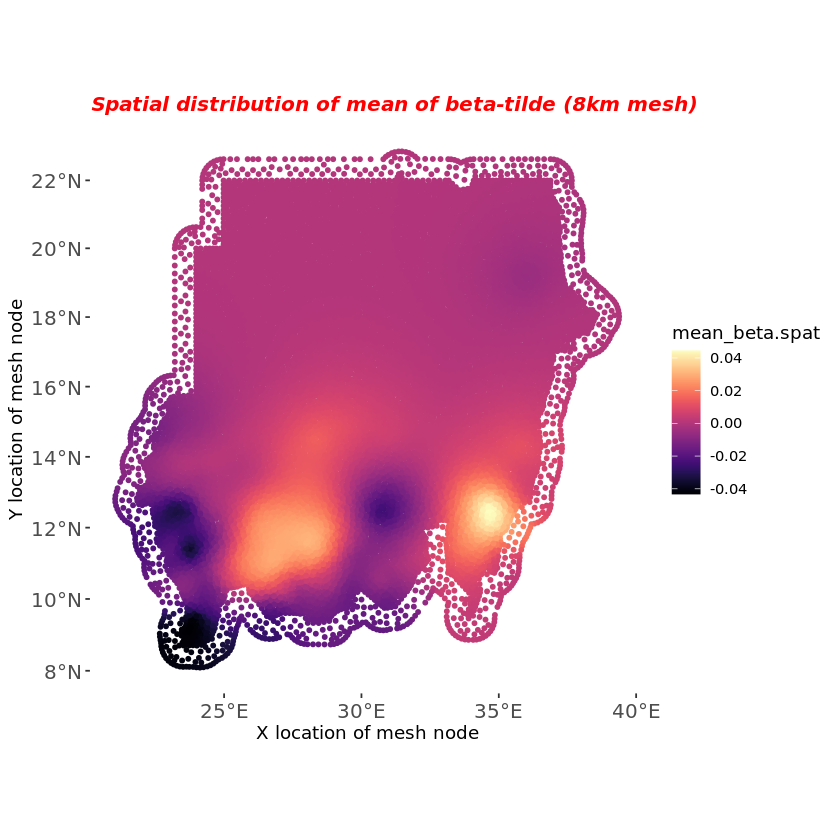

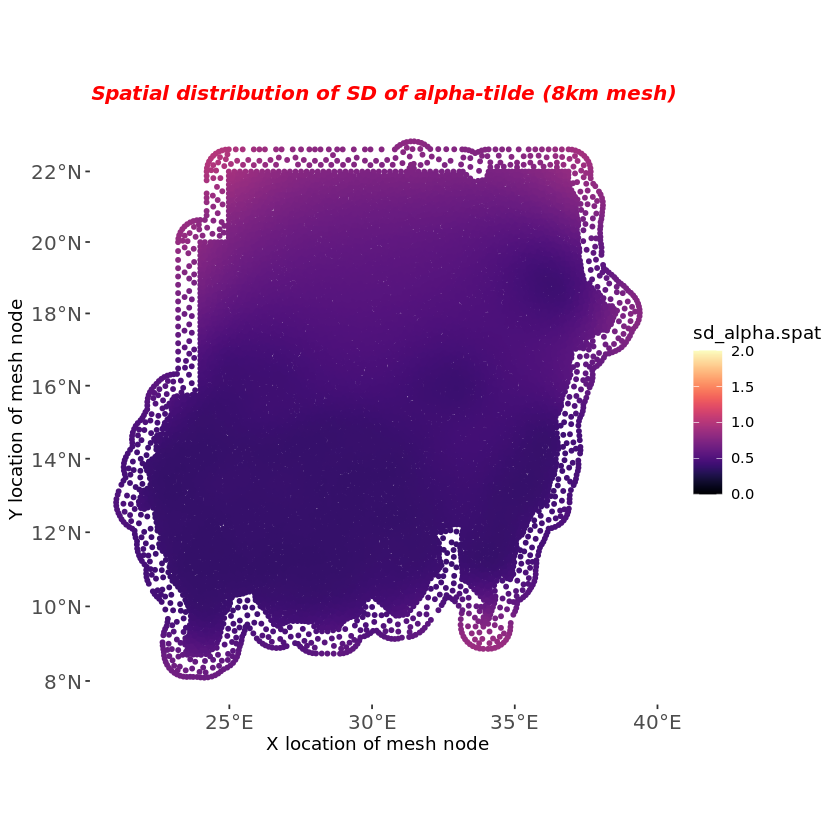

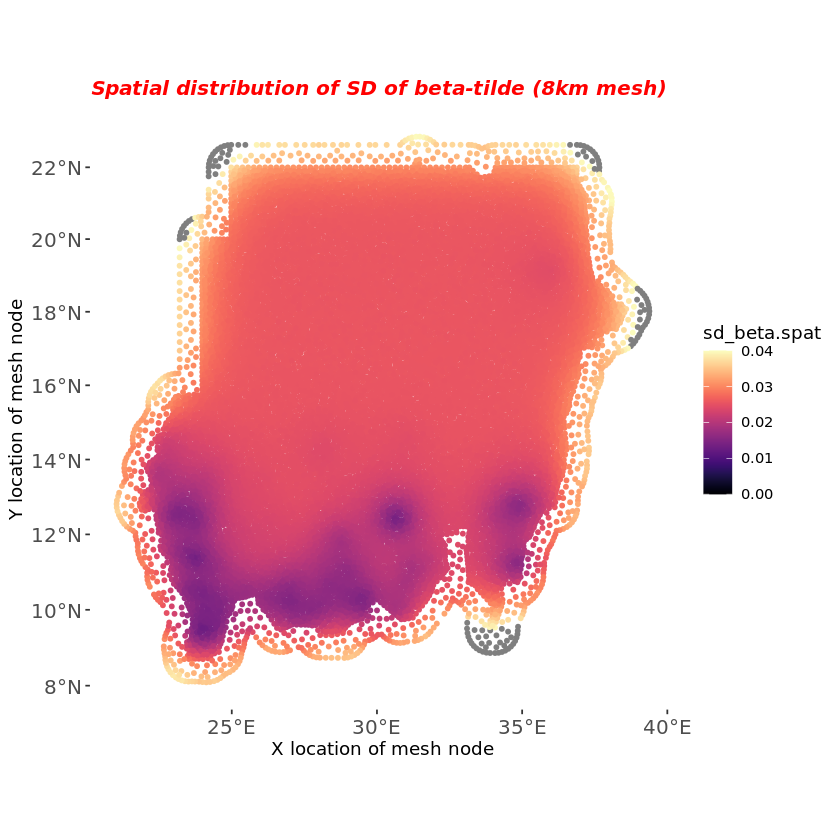

In [101]:
############################ UNDERSTANDING THE RESULTS OF THE MODEL #######################
options(repr.plot.width=3, repr.plot.height=3)

# When inla() is executed, we obtain an object of class "inla" that contains the information of the fitted model 
# including summaries and posterior marginal densities of the fixed effects, 
# the random effects, and the hyperparameters (and many more things, but we explore only these for now). 

# The fixed effects are straighforward to understand. Below, we see the posterior elements of the intercept alpha, and parameters beta and eta. 
alpha <- model_fit$marginals.fixed[[1]]
beta <- model_fit$marginals.fixed[[2]]
ggplot(data.frame(inla.smarginal(alpha)), aes(x, y)) + geom_line() + theme_bw() + xlab("Alpha") + ylab("Density")
ggplot(data.frame(inla.smarginal(beta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Beta") + ylab("Density")

# The random effects, in our case, are also easy to understand from the model outputs. The posterior distributions of the range and SD of alpha.spat, 
# beta.spat and eta.spat show us how these random effects vary across Mexico.

options(repr.plot.width=7, repr.plot.height=7)

mean_alpha.spat <- model_fit$summary.random[[1]]$mean # mean values of alpha.spat at each mesh vertex
sd_alpha.spat <- model_fit$summary.random[[1]]$sd # standard deviation of alpha.spat at each mesh node 

mean_beta.spat <- model_fit$summary.random[[2]]$mean # mean values of alpha.spat at each mesh vertex
sd_beta.spat <- model_fit$summary.random[[2]]$sd # standard deviation of alpha.spat at each mesh node  

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_alpha.spat),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of alpha-tilde (8km mesh)") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=12),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_beta.spat),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of beta-tilde (8km mesh)") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=12),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_alpha.spat),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma",limits=c(0,2)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of alpha-tilde (8km mesh)") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=12),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_beta.spat),size=1) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma",limits=c(0,0.04)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of beta-tilde (8km mesh)") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=12),axis.title=element_text())

# DIC, WAIC and the CPO and PIT are standard Bayesian model diagnostics, which tell us how our model is performing. 

Reading layer `Id_4' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_4.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.84084 ymin: 8.684103 xmax: 36.5489 ymax: 14.86612
Geodetic CRS:  WGS 84
Reading layer `biomass_carbon_bysu_20241009_withstrataid' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg' 
  using driver `GPKG'
Simple feature collection with 784 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 22.2243 ymin: 9.307635 xmax: 37.53202 ymax: 21.83538
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


[1] "Mean direct estimate AGBD: 9.30517631195841"
[1] "Mean predicted AGBD: 12.3"
[1] "Predicted SD of AGBD: 1.17"


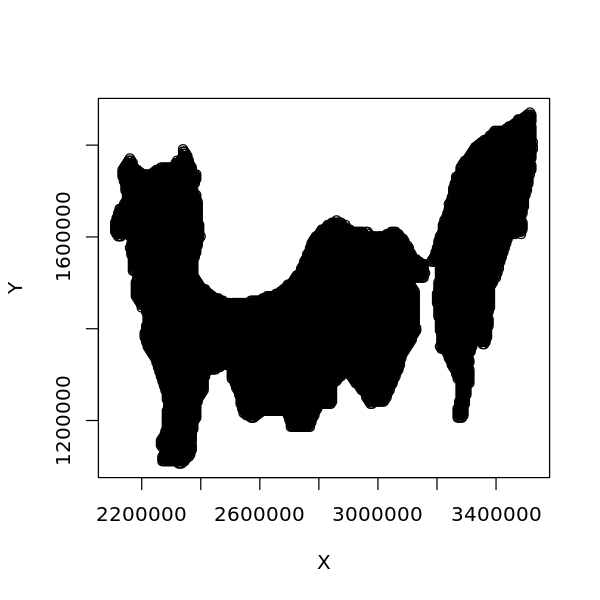

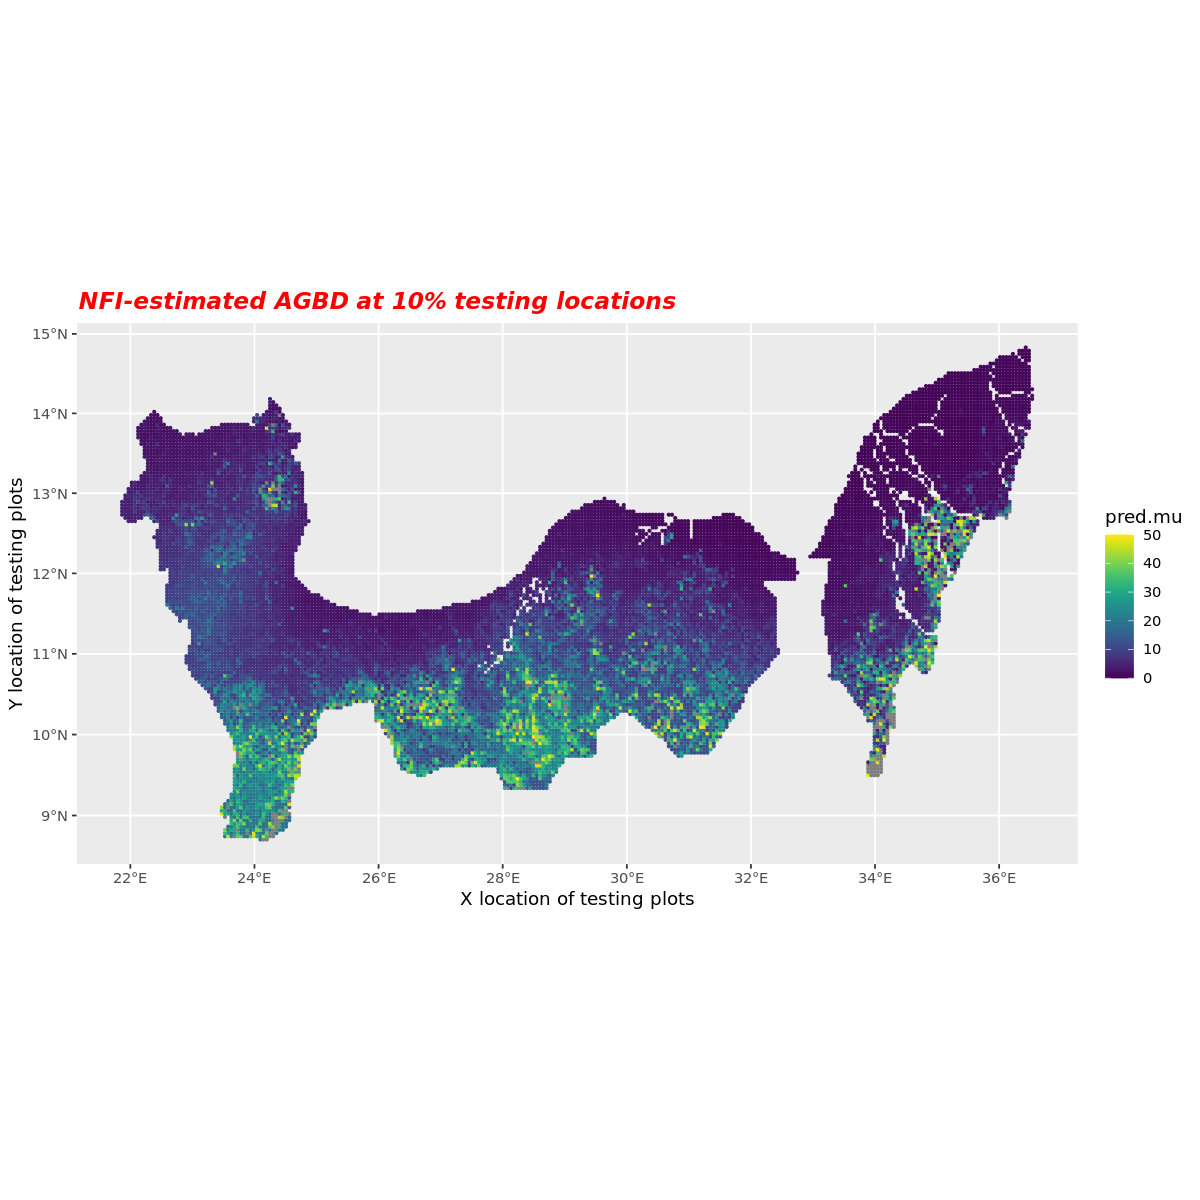

In [107]:
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_4.gpkg")
NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
NFI_subset <- st_intersection(NFI, Sudan)
DIRECT_ESTIMATE <- mean(NFI_subset$AG_Biomass..Mg.ha.,na.rm=TRUE)

Sudan <- Sudan %>% st_transform(crs=6933)

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(5000,5000), what = "centers") %>% st_as_sf() %>% st_filter(Sudan)
grid = as.data.frame(grid_to_predict %>% st_coordinates())
grid_to_predict_4326 <- grid_to_predict %>% st_transform(crs=4326)
plot(grid)

GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif")
GEDI.pred = terra::extract(GEDI_L4A, grid_to_predict_4326)
GEDI.pred = GEDI.pred$GEDI_L4A_AGB_Sudan

FNF.pred = terra::extract(FNF,grid_to_predict_4326)
FNF.pred = FNF.pred$probability_1
FNF.pred[FNF.pred<THRESHOLD_FOREST_PROBABILITY] = NA
FNF.pred[FNF.pred>=THRESHOLD_FOREST_PROBABILITY] = 1

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    GEDI.pred*L4A +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
pred.samples[pred.samples < 0] = 0
pred.samples = pred.samples*FNF.pred # forces the non-forest areas to be set to NA 

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, var)
options(repr.plot.width=5, repr.plot.height=5)

# Model mean AGBD expectations and SD of the strata
Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)

print(paste0("Mean direct estimate AGBD: ", DIRECT_ESTIMATE))
print(paste0("Mean predicted AGBD: ", Strata_mean))
print(paste0("Predicted SD of AGBD: ", Strata_SD))

options(repr.plot.width=10, repr.plot.height=10)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 50)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

Reading layer `Id_3' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_3.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 22.38587 ymin: 11.47029 xmax: 37.45337 ymax: 17.31446
Geodetic CRS:  WGS 84
Reading layer `biomass_carbon_bysu_20241009_withstrataid' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg' 
  using driver `GPKG'
Simple feature collection with 784 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 22.2243 ymin: 9.307635 xmax: 37.53202 ymax: 21.83538
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


[1] "Mean direct estimate AGBD: 1.06948567924528"
[1] "Mean predicted AGBD: 1.42"
[1] "Predicted SD of AGBD: 0.13"


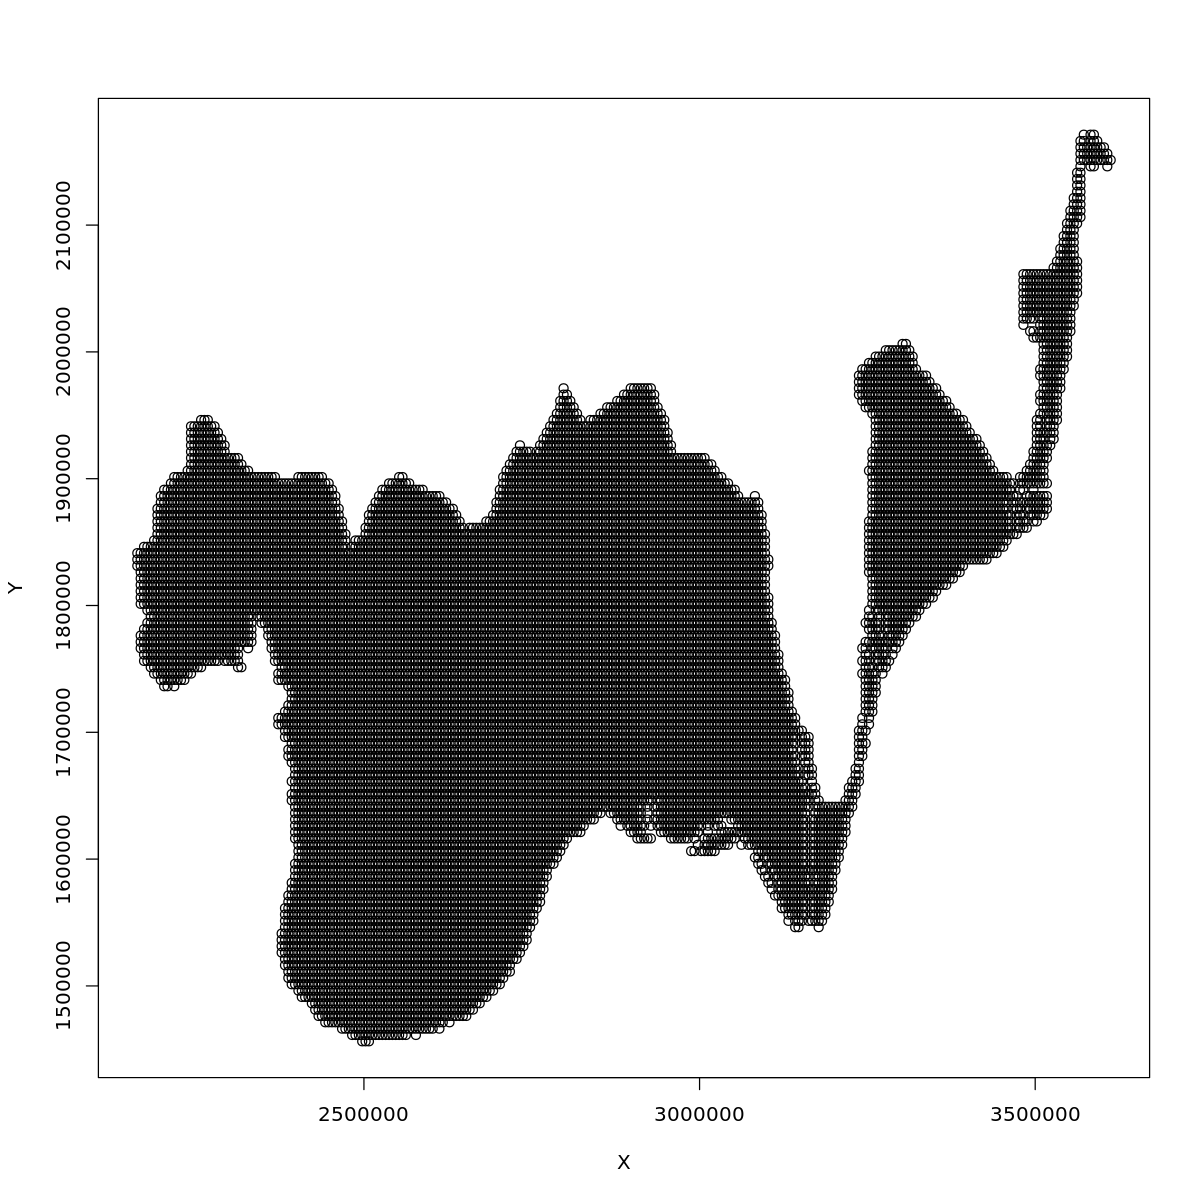

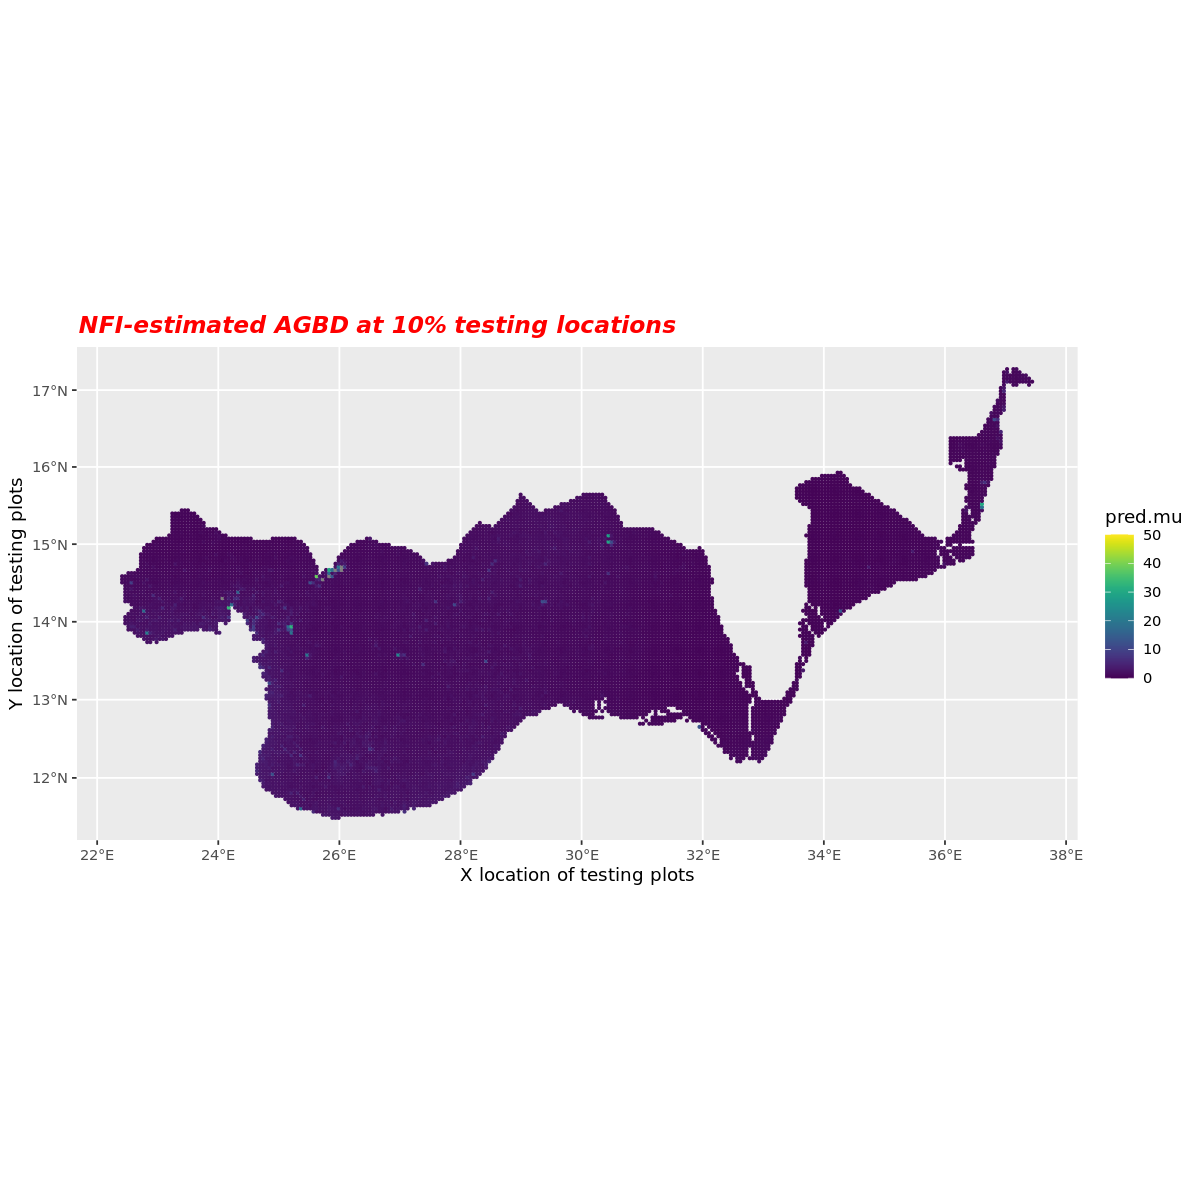

In [109]:
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_3.gpkg")
NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
NFI_subset <- st_intersection(NFI, Sudan)
DIRECT_ESTIMATE <- mean(NFI_subset$AG_Biomass..Mg.ha.,na.rm=TRUE)

Sudan <- Sudan %>% st_transform(crs=6933)

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(5000,5000), what = "centers") %>% st_as_sf() %>% st_filter(Sudan)
grid = as.data.frame(grid_to_predict %>% st_coordinates())
grid_to_predict_4326 <- grid_to_predict %>% st_transform(crs=4326)
plot(grid)

GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif")
GEDI.pred = terra::extract(GEDI_L4A, grid_to_predict_4326)
GEDI.pred = GEDI.pred$GEDI_L4A_AGB_Sudan

FNF.pred = terra::extract(FNF,grid_to_predict_4326)
FNF.pred = FNF.pred$probability_1
FNF.pred[FNF.pred<THRESHOLD_FOREST_PROBABILITY] = NA
FNF.pred[FNF.pred>=THRESHOLD_FOREST_PROBABILITY] = 1

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    GEDI.pred*L4A +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
pred.samples[pred.samples < 0] = 0
pred.samples = pred.samples*FNF.pred # forces the non-forest areas to be set to NA 

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, var)
options(repr.plot.width=5, repr.plot.height=5)

# Model mean AGBD expectations and SD of the strata
Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)

print(paste0("Mean direct estimate AGBD: ", DIRECT_ESTIMATE))
print(paste0("Mean predicted AGBD: ", Strata_mean))
print(paste0("Predicted SD of AGBD: ", Strata_SD))

options(repr.plot.width=10, repr.plot.height=10)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 50)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

Reading layer `Id_2' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_2.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 22.76638 ymin: 12.97285 xmax: 38.58349 ymax: 20.97901
Geodetic CRS:  WGS 84
Reading layer `biomass_carbon_bysu_20241009_withstrataid' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg' 
  using driver `GPKG'
Simple feature collection with 784 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 22.2243 ymin: 9.307635 xmax: 37.53202 ymax: 21.83538
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


[1] "Mean direct estimate AGBD: 0.161831"
[1] "Mean predicted AGBD: 2.52"
[1] "Predicted SD of AGBD: 1.6"


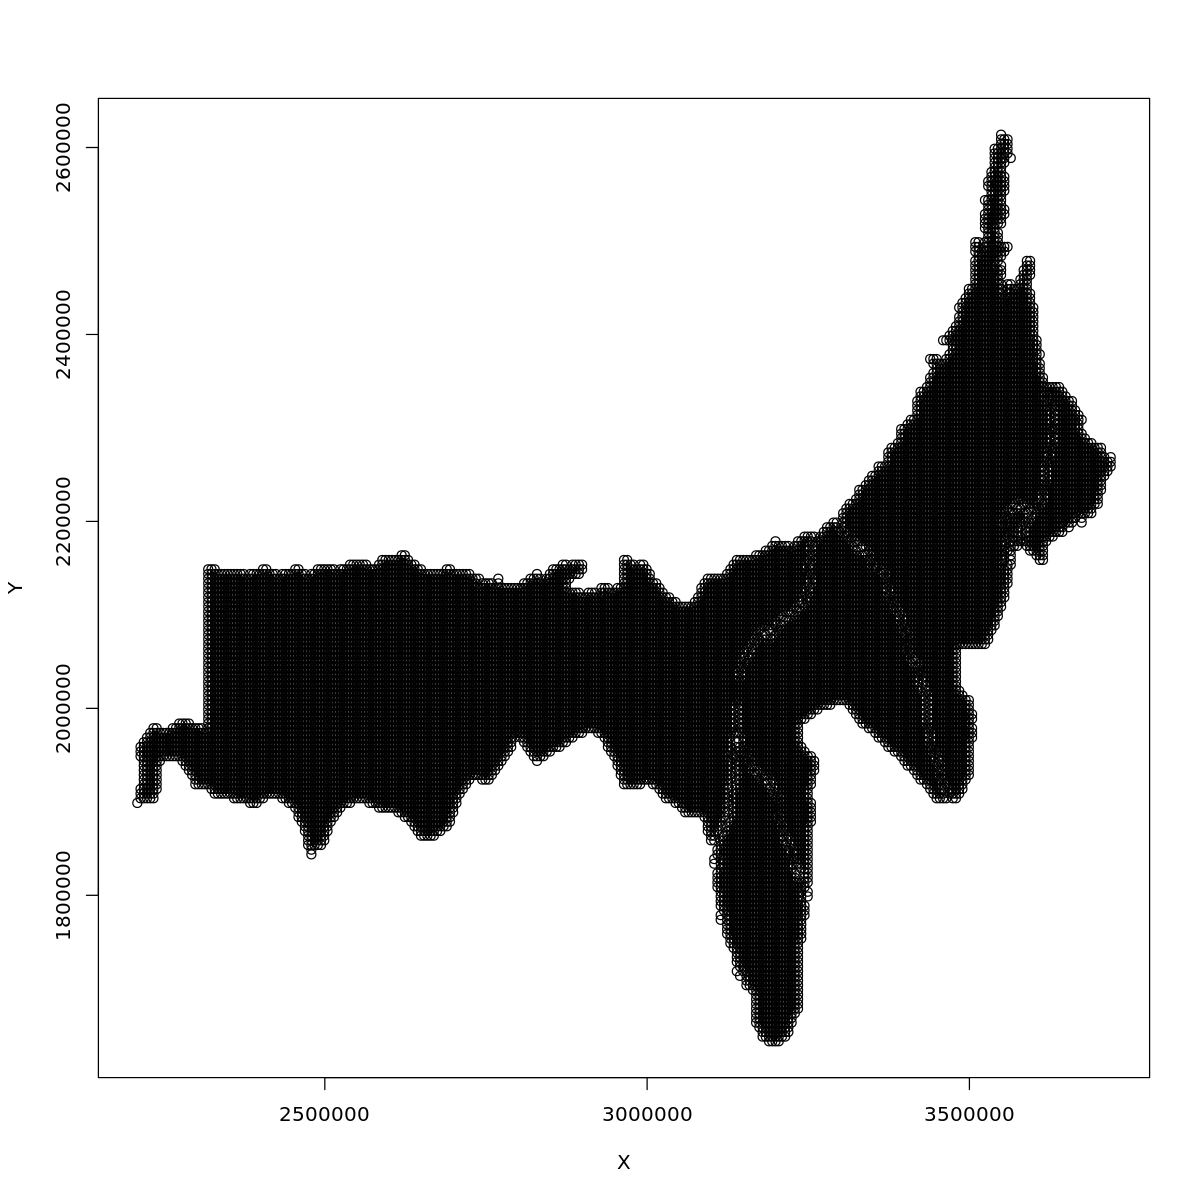

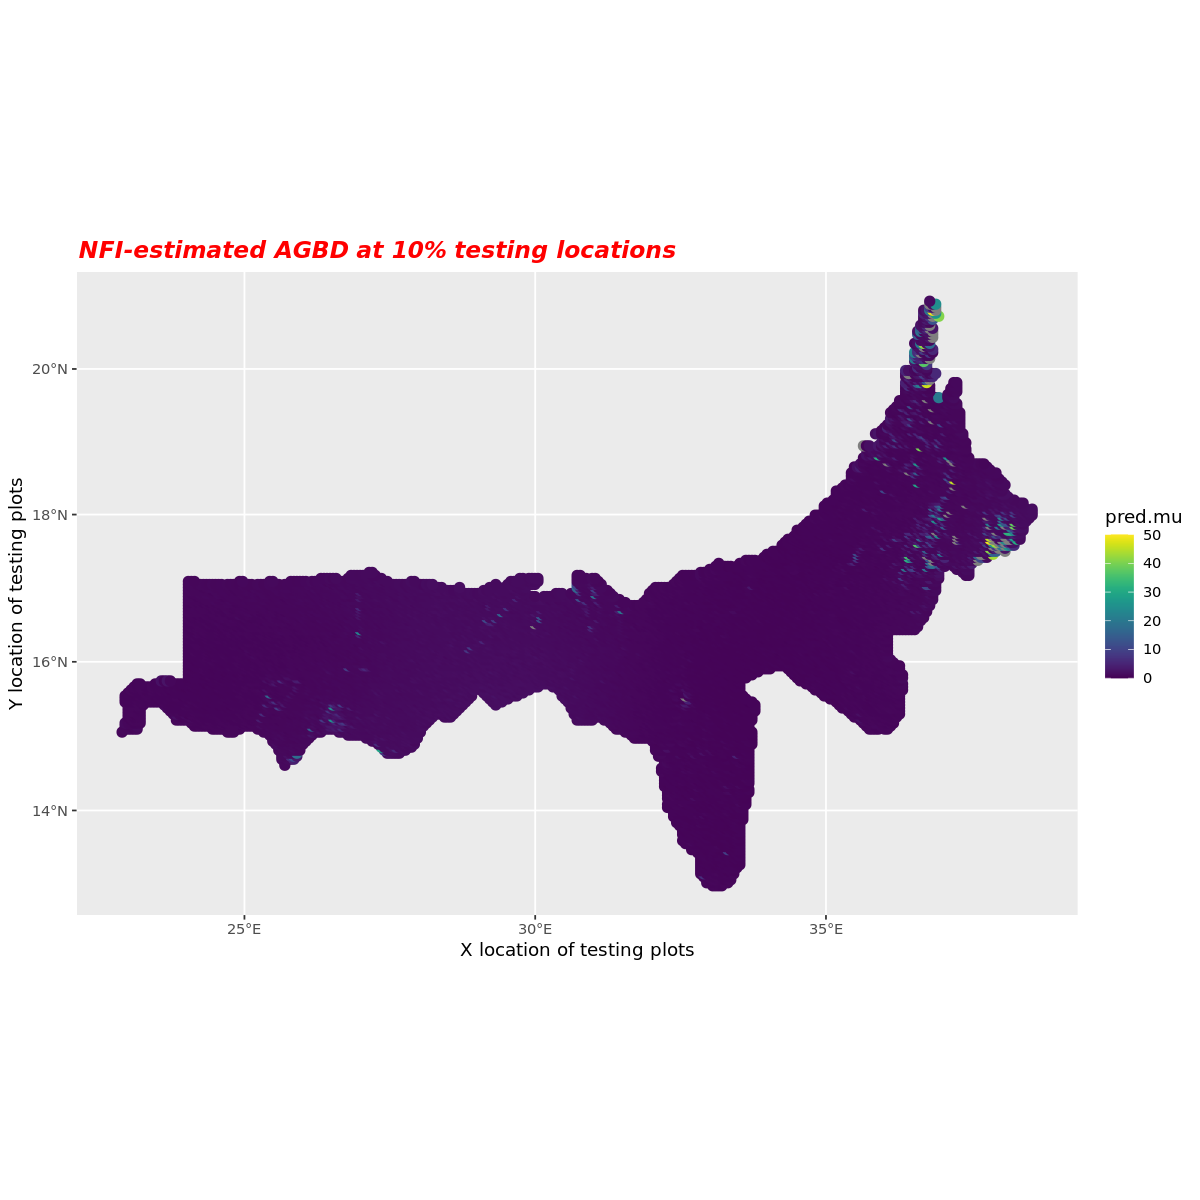

In [112]:
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_2.gpkg")
NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
NFI_subset <- st_intersection(NFI, Sudan)
DIRECT_ESTIMATE <- mean(NFI_subset$AG_Biomass..Mg.ha.,na.rm=TRUE)

Sudan <- Sudan %>% st_transform(crs=6933)

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(5000,5000), what = "centers") %>% st_as_sf() %>% st_filter(Sudan)
grid = as.data.frame(grid_to_predict %>% st_coordinates())
grid_to_predict_4326 <- grid_to_predict %>% st_transform(crs=4326)
plot(grid)

GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif")
GEDI.pred = terra::extract(GEDI_L4A, grid_to_predict_4326)
GEDI.pred = GEDI.pred$GEDI_L4A_AGB_Sudan

FNF.pred = terra::extract(FNF,grid_to_predict_4326)
FNF.pred = FNF.pred$probability_1
FNF.pred[FNF.pred<THRESHOLD_FOREST_PROBABILITY] = NA
FNF.pred[FNF.pred>=THRESHOLD_FOREST_PROBABILITY] = 1

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    GEDI.pred*L4A +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
pred.samples[pred.samples < 0] = 0
pred.samples = pred.samples*FNF.pred # forces the non-forest areas to be set to NA 

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, var)
options(repr.plot.width=5, repr.plot.height=5)

# Model mean AGBD expectations and SD of the strata
Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)

print(paste0("Mean direct estimate AGBD: ", DIRECT_ESTIMATE))
print(paste0("Mean predicted AGBD: ", Strata_mean))
print(paste0("Predicted SD of AGBD: ", Strata_SD))

options(repr.plot.width=10, repr.plot.height=10)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=2.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 50)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

Reading layer `Id_1' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_1.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 23.99951 ymin: 16.76496 xmax: 37.31689 ymax: 23.13772
Geodetic CRS:  WGS 84
Reading layer `biomass_carbon_bysu_20241009_withstrataid' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg' 
  using driver `GPKG'
Simple feature collection with 784 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 22.2243 ymin: 9.307635 xmax: 37.53202 ymax: 21.83538
Geodetic CRS:  WGS 84


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


[1] "Mean direct estimate AGBD: NaN"
[1] "Mean predicted AGBD: 1.25"
[1] "Predicted SD of AGBD: 1.03"


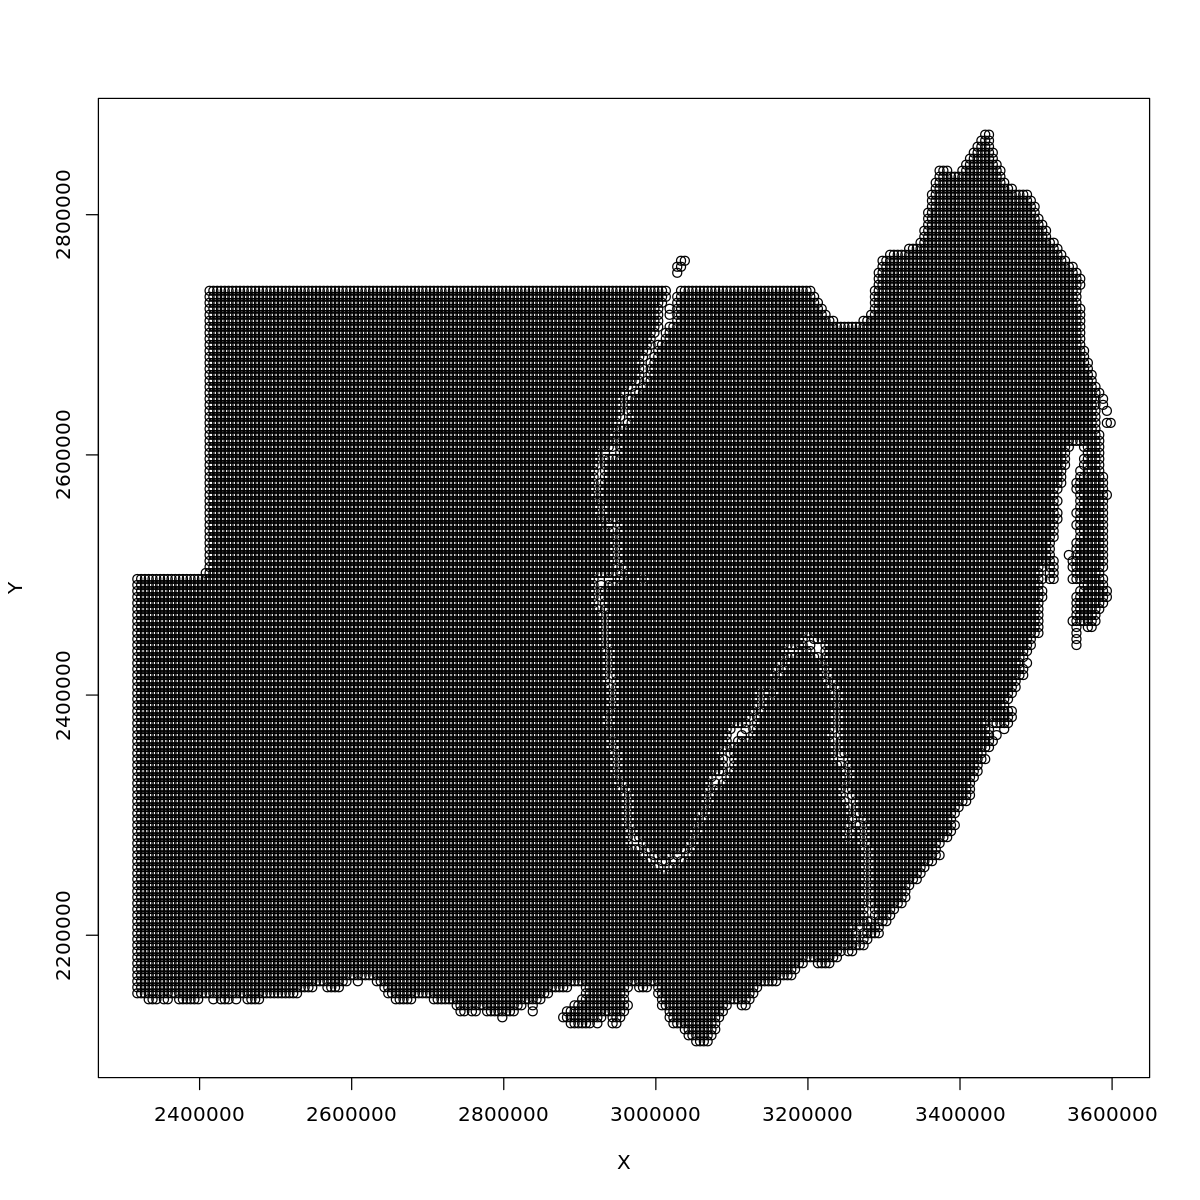

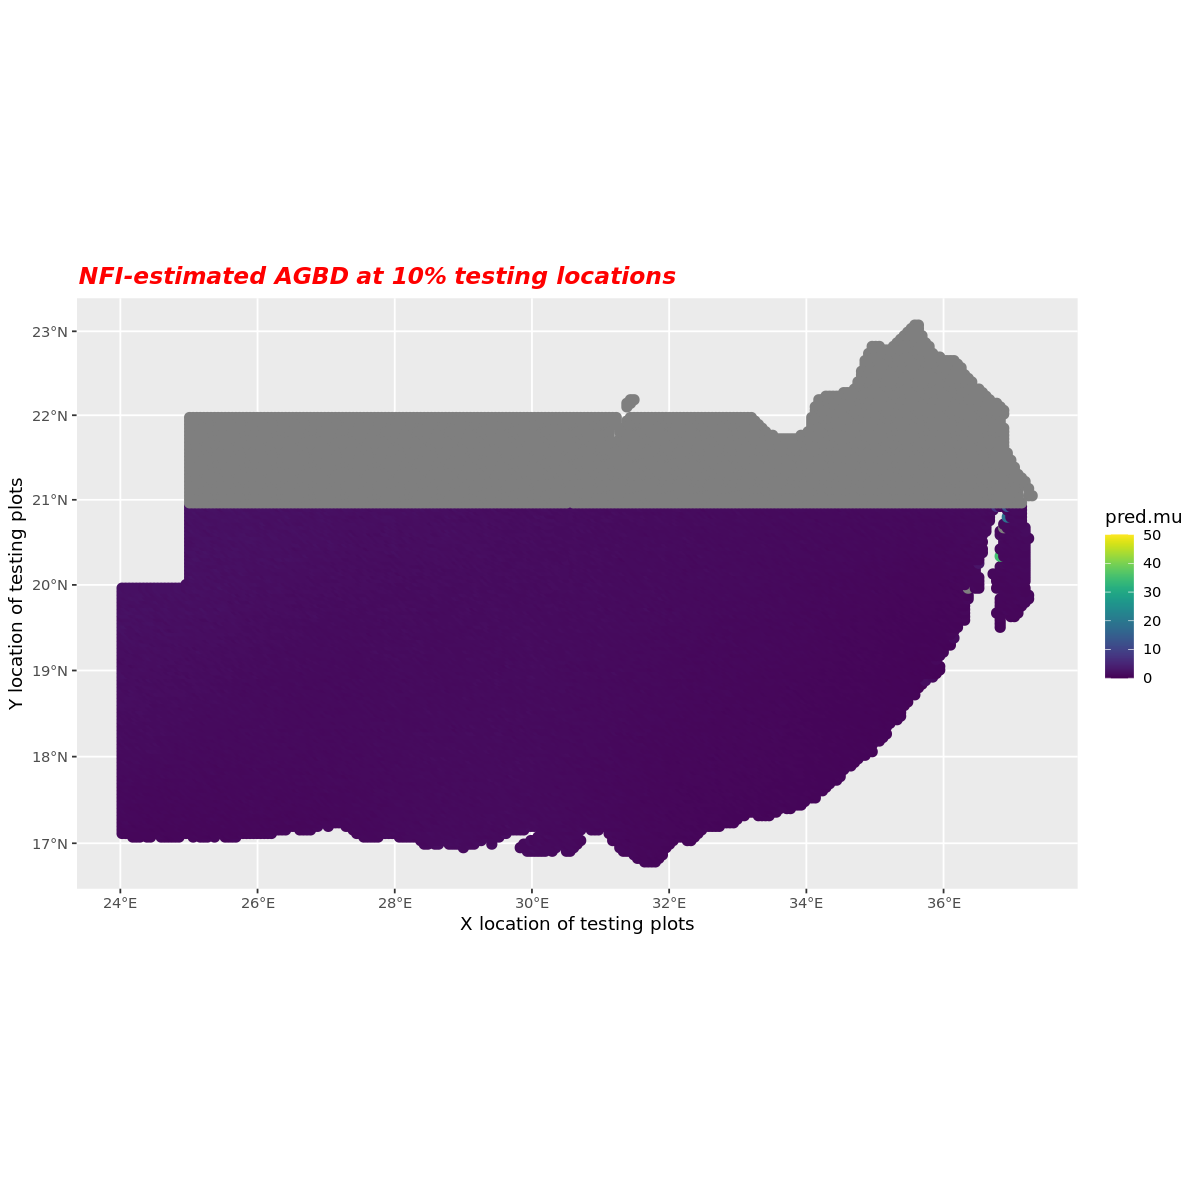

In [115]:
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Id_1.gpkg")
NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
NFI_subset <- st_intersection(NFI, Sudan)
DIRECT_ESTIMATE <- mean(NFI_subset$AG_Biomass..Mg.ha.,na.rm=TRUE)

Sudan <- Sudan %>% st_transform(crs=6933)

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
grid_to_predict = st_make_grid(Sudan, cellsize = c(5000,5000), what = "centers") %>% st_as_sf() %>% st_filter(Sudan)
grid = as.data.frame(grid_to_predict %>% st_coordinates())
grid_to_predict_4326 <- grid_to_predict %>% st_transform(crs=4326)
plot(grid)

GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif")
GEDI.pred = terra::extract(GEDI_L4A, grid_to_predict_4326)
GEDI.pred = GEDI.pred$GEDI_L4A_AGB_Sudan

FNF.pred = terra::extract(FNF,grid_to_predict_4326)
FNF.pred = FNF.pred$probability_1
FNF.pred[FNF.pred<THRESHOLD_FOREST_PROBABILITY] = NA
FNF.pred[FNF.pred>=THRESHOLD_FOREST_PROBABILITY] = 1

loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
    GEDI.pred*L4A +
    A.pred%*%alpha.spat[1:k] +   
    Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k]) + 
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
pred.samples[pred.samples < 0] = 0
pred.samples = pred.samples*FNF.pred # forces the non-forest areas to be set to NA 

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, var)
options(repr.plot.width=5, repr.plot.height=5)

# Model mean AGBD expectations and SD of the strata
Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)

print(paste0("Mean direct estimate AGBD: ", DIRECT_ESTIMATE))
print(paste0("Mean predicted AGBD: ", Strata_mean))
print(paste0("Predicted SD of AGBD: ", Strata_SD))

options(repr.plot.width=10, repr.plot.height=10)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=2.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 50)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("NFI-estimated AGBD at 10% testing locations") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

In [ ]:
# xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.mu)
# PREDICTIONS <- rasterFromXYZ(xyz_data)
# crs(PREDICTIONS) <- CRS("+init=epsg:6933")
# writeRaster(PREDICTIONS, file_tif_mean, format = "GTiff", overwrite=TRUE)

# xyz_data <- data.frame(x = loc.plot_T[,1], y = loc.plot_T[,2], z = pred.sd)
# PREDICTIONS <- rasterFromXYZ(xyz_data)
# crs(PREDICTIONS) <- CRS("+init=epsg:6933")
# writeRaster(PREDICTIONS, file_tif_SD, format = "GTiff", overwrite=TRUE)

In [ ]:
# NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
# file_list <- Sys.glob("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_country.gpkg")

# Sudan <- st_read(file_list) 
# NFI_subset <- st_intersection(NFI, Sudan)
# plot(Sudan)

# ##### MOSAIC CCI, HANSEN, OR GLAD HEIGHT ESTIMATES ##########
# ##### MOSAIC CCI, HANSEN, OR GLAD HEIGHT ESTIMATES ##########
# ##### MOSAIC CCI, HANSEN, OR GLAD HEIGHT ESTIMATES ##########

# Grid_set <- function(maps,verbose=FALSE){
#     gt <- GridTopology(c(-180 + 5, -60 + 5), c(10, 10), c(36,14))
#     grd <- SpatialGrid(gt, proj4string="+init=epsg:4326")
#     spix <- as(grd, "SpatialPixels")
#     spol <- as(spix, "SpatialPolygons")
# }

# HANSEN_LIST <- function(tiles,aoi){
#     maps_AOImasked_Hansen_masked <- ''
#     file_prefixs <- ''
#     EMask_folder <- "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN"
#     for (n in 1:length(tiles)) {
#         tile <- tiles[n]
#         min_x <- bbox(tile)[1, 1]
#         max_y <- bbox(tile)[2, 2]
#         if (min_x < 0) {
#           min_x <- paste0(sprintf('%03i', abs(min_x)),'W')
#         } else {
#           min_x <- paste0(sprintf('%03i', min_x),'E')
#         }
#         if (max_y < 0) {
#           max_y <- paste0(sprintf('%02i', abs(max_y)),'S')
#         } else {
#           max_y <- paste0(sprintf('%02i', max_y),'N')
#         }
#         file_prefix <- paste0(EMask_folder,'/','treecover2010_', max_y,'_', min_x,'.tif')
#         file_prefixs[n] <- file_prefix
#     }

#     file_prefixs <- file_prefixs[file_prefixs != ""]
#     return(file_prefixs)
# }

# CCI_LIST <- function(tiles,aoi){
#     maps_AOImasked_Hansen_masked <- ''
#     file_prefixs <- ''
#     EMask_folder <- "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN"
#     for (n in 1:length(tiles)) {
#         tile <- tiles[n]
#         min_x <- bbox(tile)[1, 1]
#         max_y <- bbox(tile)[2, 2]
#         if (min_x < 0) {
#           min_x <- paste0('W',sprintf('%03i', abs(min_x)))
#         } else {
#           min_x <- paste0('E',sprintf('%03i', min_x))
#         }
#         if (max_y < 0) {
#           max_y <- paste0('S',sprintf('%02i', abs(max_y)))
#         } else {
#           max_y <- paste0('N',sprintf('%02i', max_y))
#         }
#         file_prefix <- paste0(EMask_folder,'/',max_y,'', min_x,'_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2021-fv5.0.tif')
#         # file_prefix <- paste0(EMask_folder,'/2020_',max_y,'_', min_x,'.tif')
#         file_prefixs[n] <- file_prefix
#     }

#     file_prefixs <- file_prefixs[file_prefixs != ""]
#     return(file_prefixs)
# }

# Grid_tiles <- Grid_set()

# intersecting <- (st_intersects(st_as_sf(Sudan),st_as_sf(Grid_tiles)))[[1]]
# nrow_tiles <- intersecting
# if (length(intersecting) == 0) {
#     stop('no intersecting CCI Biomass tiles found')
# } else {tiles <- (Grid_tiles[nrow_tiles,])}

# # HANSEN_LIST <- HANSEN_LIST(tiles=tiles,aoi=Sudan)
# # if (length(HANSEN_LIST) > 1){ 
# #     r_lst <- lapply(HANSEN_LIST, rast)
# #     coll <- sprc(r_lst)
# #     HANSEN <- terra::mosaic(coll, fun = "mean")
# # } else {HANSEN <- rast(HANSEN_LIST)} #%>% project("epsg:6933")
# # names(HANSEN) <- c("TC")
# # HANSEN.plot = terra::extract(HANSEN, NFI)
# # writeRaster(HANSEN, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/HANSEN_TC_Sudan.tif",gdal=c("COMPRESS=LZW"), overwrite=TRUE)
# rm(HANSEN)

# CCI_LIST <- CCI_LIST(tiles=tiles,aoi=Sudan)
# if (length(CCI_LIST) > 1){ 
#     r_lst <- lapply(CCI_LIST, rast)
#     coll <- sprc(r_lst)
#     CCI <- terra::mosaic(coll, fun = "mean")
# } else {CCI <- rast(CCI_LIST)} #%>% project("epsg:6933")
# names(CCI) <- c("AGB")
# CCI.plot = terra::extract(CCI, NFI)
# NFI['CCI'] <- CCI.plot$AGB
# writeRaster(CCI, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/CCI_AGB_Sudan.tif", gdal=c("COMPRESS=LZW"), overwrite=TRUE)
# # writeRaster(CCI, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/POTAPOV_Height_Sudan.tif", gdal=c("COMPRESS=LZW"), overwrite=TRUE)
# rm(CCI)

In [27]:
# NFI['HEIGHT'] <- CCI.plot$AGB
# NFI['TC'] <- HANSEN.plot$TC
# NFI['CCI'] <- CCI.plot$AGB
# write.csv(NFI %>% st_drop_geometry(),"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv",row.names=FALSE) #Save the data

# NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
# NFI_6933 <- NFI %>% st_transform(crs=6933)

# GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif")
# L4A.plot = terra::extract(GEDI_L4A, NFI)
# length(L4A.plot$GEDI_L4A_AGB_Sudan)
# sum(is.na(L4A.plot$GEDI_L4A_AGB_Sudan))
# length(L4A.plot$GEDI_L4A_AGB_Sudan[L4A.plot$GEDI_L4A_AGB_Sudan == 0])

# NFI <- st_read("/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg")
# NFI_6933 <- NFI %>% st_transform(crs=6933)

# GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif")
# L4A.plot = terra::extract(GEDI_L4A, NFI)
# NFI = read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv")
# NFI['GEDI_L4A'] = L4A.plot$GEDI_L4A_AGB_Sudan
# NFI['X'] = st_coordinates(NFI_6933)[,1]
# NFI['Y'] = st_coordinates(NFI_6933)[,2]
# colnames(NFI)
# write.csv(NFI,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/NFI_and_COVARIATES.csv",row.names=FALSE) #Save the data

Reading layer `biomass_carbon_bysu_20241009_withstrataid' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Sudan/Sudan_NFI.gpkg' 
  using driver `GPKG'
Simple feature collection with 784 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 22.2243 ymin: 9.307635 xmax: 37.53202 ymax: 21.83538
Geodetic CRS:  WGS 84


[1] 784

[1] 1

[1] 86

In [ ]:
# ##### MOSAIC GRIDDED L4A ESTIMATES ##########
# ##### MOSAIC GRIDDED L4A ESTIMATES ##########
# ##### MOSAIC GRIDDED L4A ESTIMATES ##########

# file_list <- Sys.glob("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Id_*_SUD_L4A.tif")
# target_res <- c(0.005, 0.005)  # Same resolution for x and y
# resampled_rasters <- list()

# r <- raster(file_list[1])
# for (file in file_list[2:length(file_list)]) {
#     reference_raster <- raster(file)
#     r_extended <- extend(r, reference_raster)
# }

# for (file in file_list) {
#     r <- raster(file)
#     r_resampled <- resample(r, r_extended, method = "ngb", 
#                             filename = tempfile(fileext = ".tif"), 
#                             options = c("COMPRESS=LZW", "TILED=YES"), 
#                             overwrite = TRUE)
#     resampled_rasters[[file]] <- r_resampled
# }

# raster_stack <- stack(resampled_rasters)
# mosaic_result <- calc(raster_stack, fun = max, na.rm = TRUE)
# writeRaster(mosaic_result, 
#               "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan.tif", 
#               format = "GTiff", 
#               options = c("COMPRESS=LZW", "TILED=YES"), 
#               overwrite = TRUE)